# Tutorial 1: **Notebook** - *FVF*

**By gLayout Team**

__Content creators:__ Subham Pal, Saptarshi Ghosh

__Content reviewers:__ Mehedi Saligne

<br>

___
# Tutorial Objectives

This notebook is a tutorial on- 

- **Importing** and **Placement** of FETs and other macros/Pcells with relative coordinates + Placing (and connecting) Via_stack on the ports of the FETs + encircling them with padrings (+and probably printing and explaining port names) 
- **Routing** between those placed Vias with C_, L_, Straight_ and smart Routes and explaining the differences between these strategies, particularly with E/W/N/S angles (For Example, why C has to parallel but L has to be perpendicular) and *Placing and connecting PINs for future LVS runs + running successful DRCs*

## **Target** **Block** : **Flipped Voltage Follwer Cell**

The Flipped Voltage Follower (FVF) is a widely used analog building block known for its low output impedance, fast transient response, and ability to deliver large output current while maintaining voltage buffering properties. It is commonly employed in analog circuit design, particularly in output stages, gain boosting, common-mode feedback circuits, and super class-AB OTAs. 

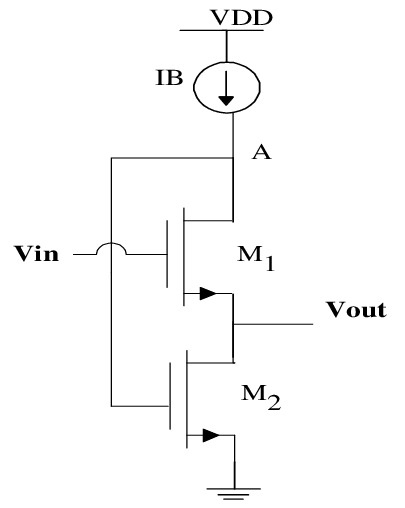

## **Layout generation**
let's go through the step by step procedure to generate LVS and DRC clean layout of a FVF cell.

In [4]:
!pip install svgutils
!pip install ipywidgets
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg('out.svg')
  # Scale the image for displaying
  fig = sg.fromfile('out.svg')
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save('out.svg')

  # Display the image
  IPython.display.display(IPython.display.SVG('out.svg'))

def display_component(component, scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds("out.gds")
  display_gds('out.gds', scale)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 276.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 654.4 kB/s eta 0:00:000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.4 MB/s eta 0:00:0000:0100:01


In [5]:
from glayout.flow.pdk.mappedpdk import MappedPDK
from glayout.flow.pdk.sky130_mapped import sky130_mapped_pdk as sky130
from glayout.flow.pdk.gf180_mapped  import gf180_mapped_pdk  as gf180
from gdsfactory.cell import cell
from gdsfactory.component import Component
from gdsfactory import Component
from glayout.flow.primitives.fet import nmos, pmos, multiplier
from glayout.flow.pdk.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.flow.pdk.util.snap_to_grid import component_snap_to_grid
from glayout.flow.pdk.util.port_utils import rename_ports_by_orientation
from glayout.flow.routing.straight_route import straight_route
from glayout.flow.routing.c_route import c_route
from glayout.flow.routing.L_route import L_route
from glayout.flow.primitives.guardring import tapring
from glayout.flow.pdk.util.port_utils import add_ports_perimeter
from glayout.flow.spice.netlist import Netlist
from glayout.flow.primitives.via_gen import via_stack
from gdsfactory.components import text_freetype, rectangle

FVF has two fets as shown in the schematic. We call M1 as input fet and M2 as feedback fet. Lets define arguments for the FETs

In [6]:
nmos_kwargs = {
    "with_tie": True,
    "with_dnwell": True,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}

pmos_kwargs = {
    "with_tie": True,
    "dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}

There is no need to manually define the kwargs for your code. This is only done for this notebook implementation.


Let's create a list for which parameters we need for our function-

* pdk: pdk to use
* device_type: either "nmos" or "pmos"
* placement: either "horizontal" or "vertical"
* width: (input fet, feedback fet)
* length: (input fet, feedback fet)
* fingers: (input fet, feedback fet)
* multipliers: (input fet, feedback fet)
* dummy_1: dummy for input fet
* dummy_2: dummy for feedback fet
* tie_layers1: tie layers for input fet
* tie_layers2: tie layers for feedback fet
* sd_rmult: sd_rmult for both fets


In [7]:
flipped_voltage_follower_config={
        "pdk": sky130, # pdk to use
        "device_type": "nmos", # either nmos or pmos
        "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width": (3,3), # width of the input fet and feedback fet respectively.
        "length": (None,None), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (1,1), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_1": (True,True), # dummy pattern for input fet (left,right)
        "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers for input fet
        "tie_layers2": ("met2","met1"), #tapring metal layers for feedback fet
        "sd_rmult":1, # thickness of the sd metal layer.
}

### First: We create a top level component and add a name

In [8]:
top_level = Component(name="flipped_voltage_follower")

### two fets

For our fvf block, we do not want deep nwell. However nmos and pmos primitives have different parameter name for deepnwell.
For pmos it is set to false by default.We need to set it to false if the device type is given as nmos.
We could've just set it properly in our nmos_kwargs, 
but since you will probably not code the layout for a notebook, we show a general way of solving this issue.


In [9]:
device_type = flipped_voltage_follower_config["device_type"]
device_map = {
        "nmos": nmos,
        "pmos":pmos,
        }
        
device = device_map.get(device_type)
if device_type == "nmos":
      nmos_kwargs["with_dnwell"] = False

In [10]:
pdk=flipped_voltage_follower_config["pdk"]
width=flipped_voltage_follower_config["width"]
length=flipped_voltage_follower_config["length"]
fingers=flipped_voltage_follower_config["fingers"]
multipliers=flipped_voltage_follower_config["multipliers"]
dummy_1=flipped_voltage_follower_config["dummy_1"]
dummy_2=flipped_voltage_follower_config["dummy_2"]
tie_layers1=flipped_voltage_follower_config["tie_layers1"]
tie_layers2=flipped_voltage_follower_config["tie_layers2"]
sd_rmult=flipped_voltage_follower_config["sd_rmult"]

In [11]:
#fet_1 is the input fet
fet_1 = device(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **(nmos_kwargs if device_type == "nmos" else pmos_kwargs))
#fet_2 is the feedback fet
fet_2 = device(pdk, width=width[1], fingers=fingers[1], multipliers=multipliers[1], with_dummy=dummy_2, with_substrate_tap=False, length=length[1], tie_layers=tie_layers2, sd_rmult=sd_rmult, **(nmos_kwargs if device_type == "nmos" else pmos_kwargs))
well = "pwell" if device == nmos else "nwell"

2025-06-08 03:33:47.970 | INFO     | gdsfactory.pdk:activate:337 - 'sky130' PDK is now active


Adding the references of the FETs to the top level component

/tmp/ipykernel_66/130218649.py:27: UserWarning: Unnamed cells, 2 in 'flipped_voltage_follower'
  component.write_gds("out.gds")
2025-06-08 03:34:01.419 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'out.gds'


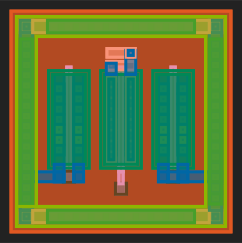

In [12]:
fet_1_ref = top_level << fet_1
fet_2_ref = top_level << fet_2

#let's take a look at our current state of layout
#top_level.show()
display_component(top_level, scale = 3)
## If you want to save the gds file at this stage
#primary_gds = top_level.write_gds("before_placement.gds")

### Placement

When a cell is referenced to the top level, the center of the cell is aligned to the (0,0) co-ordinate.
As of now, both of our fets are centered at (0,0). We need place them properly depending on the placement parameter.

In [13]:
placement=flipped_voltage_follower_config["placement"]

ref_dimensions = evaluate_bbox(fet_2)


evaluate_bbox returns maximum width and maximum height of the block as a tuple(width,height).

So here we have `ref_dimensions=(x-dimension of fet_2, y-dimension of fet_2)`

For horizontal placement , we need to move the fet_2 in rightward direction.
We use the movex function, which moves the center of the block in x-directon upto a certain distance. We need to find out this distance.
Remember that both fet_1 and fet_2 are centered at (0,0) co-ordinate right now.
At first we move the center of fet_2 to rightmost point of fet_1 using the xmax function, i.e, (fet_1_ref.xmax,0).
Now we will find that left half of fet_2 is overlapping with fet_1, so we need to move it at rightward direction again.We move it by ref_dimensionsp[0]/2 distance.
Now we see that the rightmost point of fet_1 and leftmost point of fet_2 have no seperation between them.
This will cause a drc error. So we move it again by max seperation needed between two metal layers for drc free layout.
We move it by 1um again for leaving some routing space for future use.

Vertical placement can be done in similar way by using movey function.

/tmp/ipykernel_66/130218649.py:27: UserWarning: Unnamed cells, 2 in 'flipped_voltage_follower'
  component.write_gds("out.gds")
2025-06-08 03:34:40.345 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'out.gds'


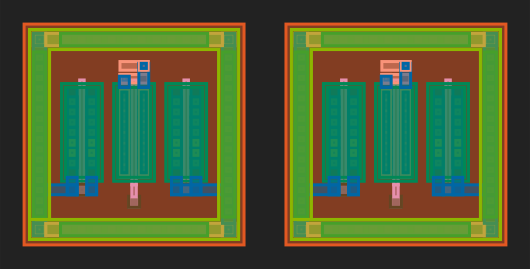

In [14]:
if placement == "horizontal":
    fet_2_ref.movex(fet_1_ref.xmax + ref_dimensions[0]/2 + pdk.util_max_metal_seperation()+1)
if placement == "vertical":
    fet_2_ref.movey(fet_1_ref.ymin - ref_dimensions[1]/2 - pdk.util_max_metal_seperation()-1)

# let's see how our block looks after placement 
display_component(top_level, scale = 3)
#top_level.show()
##placement_gds = top_level.write_gds("after_placement.gds")

 ### Routing

Now that our fets are properly placed, we need to make proper connections between ports.
Each port has four directions- E,N,W,S which means 0,90,180,270 degrees respectively.
You can connect directly to a fet port. For better felxibility in routing, we choose add some intermediate vias here.


In [15]:
viam2m3 = via_stack(pdk, "met2", "met3", centered=True) #met2 is the bottom layer. met3 is the top layer.

#we need four such vias
drain_1_via = top_level << viam2m3
source_1_via = top_level << viam2m3
drain_2_via = top_level << viam2m3
gate_2_via = top_level << viam2m3

The move function moves the center of a specific cell to a specific co-ordinate.
The co-ordinates of the center of a port can be accesed by using cell_name.ports["port_name"].center
Using these two and other techniques previously discussed, we properly place these 4 vias.

/tmp/ipykernel_66/130218649.py:27: UserWarning: Unnamed cells, 2 in 'flipped_voltage_follower'
  component.write_gds("out.gds")
2025-06-08 03:35:00.244 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'out.gds'


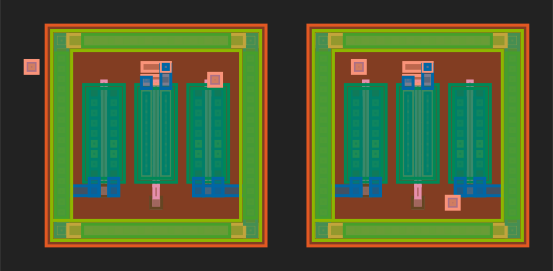

In [16]:
drain_1_via.move(fet_1_ref.ports["multiplier_0_drain_W"].center).movex(-0.5*evaluate_bbox(fet_1)[1])
source_1_via.move(fet_1_ref.ports["multiplier_0_source_E"].center).movex(1.5)
drain_2_via.move(fet_2_ref.ports["multiplier_0_drain_W"].center).movex(-1.5)
gate_2_via.move(fet_2_ref.ports["multiplier_0_gate_E"].center).movex(1)

# let's see where those vias are now
#top_level.show()
display_component(top_level, scale = 3)
##viaplacement_gds = top_level.write_gds("via_placement.gds")

Now that the vias are placed, time to make metal routing.
There are three basic types of routing available:

- `straight_route` - the ports must be straight to each other, i.e, opposite direction and same x or y coordinate.
- `L_route` - has a 90&deg; bend, ports must be perpendicular to each other.
- `c_route` -  has two 90&deg; bends(c shaped), ports must have same direction.

Each routing function has multiple parameters. See [here](https://github.com/idea-fasoc/OpenFASOC/tree/main/openfasoc/generators/glayout/glayout/flow/routing)

Bonus: You can see all avaliable ports by `top_level.pprint_ports()`

From the schematic, we see that we need to connect these two nodes-

1. Source of M1 and Drain of M2, we insert two intermediate vias near each of them and connect them.
2. Gate of M2 and Drain of M1, we insert two intermediate vias near each of them and connect them.

/tmp/ipykernel_66/130218649.py:27: UserWarning: Unnamed cells, 2 in 'flipped_voltage_follower'
  component.write_gds("out.gds")
2025-06-08 03:35:22.833 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'out.gds'


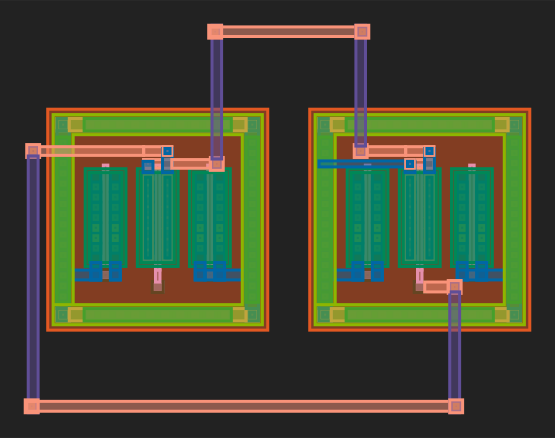

In [17]:
top_level << straight_route(pdk, fet_1_ref.ports["multiplier_0_source_E"], source_1_via.ports["bottom_met_W"])
top_level << straight_route(pdk, fet_2_ref.ports["multiplier_0_drain_W"], drain_2_via.ports["bottom_met_E"])
top_level << c_route(pdk, source_1_via.ports["top_met_N"], drain_2_via.ports["top_met_N"], extension=1.2*max(width[0],width[1]), width1=0.32, width2=0.32, cwidth=0.32, e1glayer="met3", e2glayer="met3", cglayer="met2")
top_level << straight_route(pdk, fet_1_ref.ports["multiplier_0_drain_W"], drain_1_via.ports["bottom_met_E"])
top_level << c_route(pdk, drain_1_via.ports["top_met_S"], gate_2_via.ports["top_met_S"], extension=1.2*max(width[0],width[1]), cglayer="met2")
top_level << straight_route(pdk, fet_2_ref.ports["multiplier_0_gate_E"], gate_2_via.ports["bottom_met_W"])
try:
    top_level << straight_route(pdk, fet_2_ref.ports["multiplier_0_source_W"], fet_2_ref.ports["tie_W_top_met_W"], glayer1=tie_layers2[1], width=0.2*sd_rmult, fullbottom=True)
except:
    pass

# let's see how those vias are now routed
#top_level.show()
display_component(top_level, scale = 3)

Notice how in the above lines, ports used in straight routing has the opposite direction, e.g. (E,W) but ports used in c_route has the same direction (N,N).

### Renaming Ports

We need to rename ports and add them to the top level component for ease of routing in hierarchial design.
Here we rename ports by adding appropriate prefix to the all ready existing port names.


In [18]:
top_level.add_ports(fet_1_ref.get_ports_list(), prefix="A_")
top_level.add_ports(fet_2_ref.get_ports_list(), prefix="B_")
top_level.add_ports(drain_1_via.get_ports_list(), prefix="A_drain_")
top_level.add_ports(source_1_via.get_ports_list(), prefix="A_source_")
top_level.add_ports(drain_2_via.get_ports_list(), prefix="B_drain_")
top_level.add_ports(gate_2_via.get_ports_list(), prefix="B_gate_")

### add nwell

for pmos device type, we need to add nwell.
However we do not need to add pwell for nmos device type as magic does not seperately extract the pwell layer.


In [19]:
if well == "nwell":
    top_level.add_padding(layers=(pdk.get_glayer("nwell"),),default= 1 )

In [20]:
shift_amount = -prec_center(top_level.flatten())[0];
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(top_level.flatten(), padding=pdk.get_grule("nwell")['min_separation']));
tring_ref = top_level << tap_ring;
tring_ref.movex(destination=shift_amount);

In [21]:
## We will add Nestlist in next Tutorial
#component.info['netlist'] = fvf_netlist(fet_1, fet_2)

In [23]:
component = component_snap_to_grid(rename_ports_by_orientation(top_level))

# Now that our block is complete, let's see how it looks now!!
#component.show()
##fvf_gds = component.write_gds("fvf.gds")

In [24]:
#Note
#The original code can be found here -https://github.com/idea-fasoc/OpenFASOC/blob/main/openfasoc/generators/glayout/glayout/flow/blocks/elementary/FVF/fvf.py

We Can Display the component here as well

2025-06-08 03:36:59.769 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'out.gds'


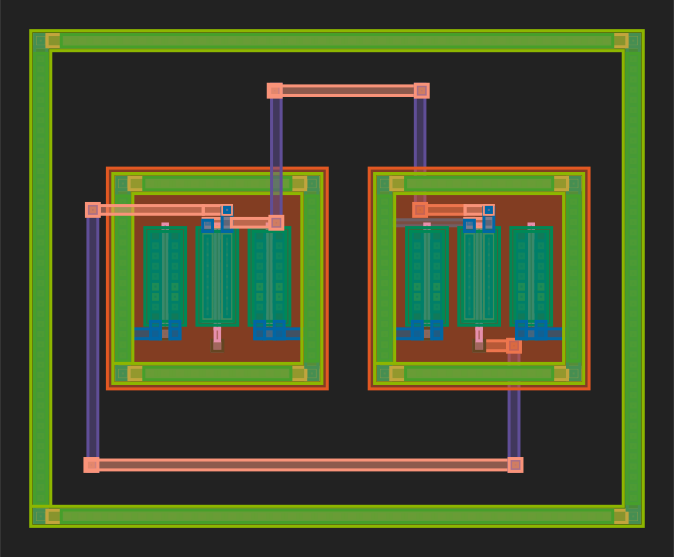

In [25]:
display_component(component, scale = 3)

### Add Ports here

/tmp/ipykernel_66/130218649.py:27: UserWarning: Unnamed cells, 3 in 'flipped_voltage_follower'
  component.write_gds("out.gds")
2025-06-08 03:37:32.425 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'out.gds'


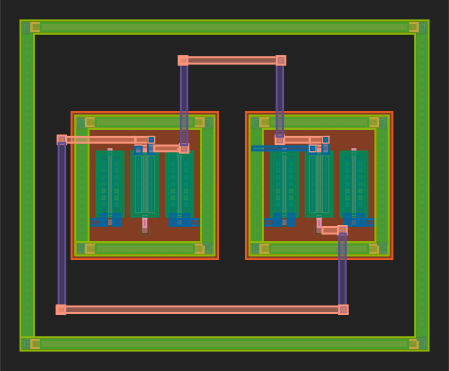

In [28]:
    # define layers`
    met1_pin = (68,16)
    met1_label = (68,5)
    met2_pin = (69,16)
    met2_label = (69,5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list
    # gnd
    gnd2label = rectangle(layer=met1_pin,size=(0.5,0.5),centered=True).copy()
    gnd2label.add_label(text="VBULK",layer=met1_label)
    move_info.append((gnd2label,component.ports["B_tie_N_top_met_N"],None))
    
    #currentbias
    ibiaslabel = rectangle(layer=met2_pin,size=(0.5,0.5),centered=True).copy()
    ibiaslabel.add_label(text="Ib",layer=met2_label)
    move_info.append((ibiaslabel,component.ports["A_drain_bottom_met_N"],None))
    
    # output (3rd stage)
    outputlabel = rectangle(layer=met2_pin,size=(0.5,0.5),centered=True).copy()
    outputlabel.add_label(text="VOUT",layer=met2_label)
    move_info.append((outputlabel,component.ports["A_source_bottom_met_N"],None))
    
    # input
    inputlabel = rectangle(layer=met1_pin,size=(0.5,0.5),centered=True).copy()
    inputlabel.add_label(text="VIN",layer=met1_label)
    move_info.append((inputlabel,component.ports["A_multiplier_0_gate_N"], None))

component = component.flatten()
display_component(top_level, scale = 2)


### Run DRC

In [29]:
import os
from pathlib import Path

component.name="fvf"
drc_result = sky130.drc_magic(component, component.name)

2025-06-08 03:39:56.070 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmpr3umnr38/fvf.gds'


using default pdk_root: /usr/bin/miniconda3/share/pdk/
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 464 - Compiled on Sat Mar  9 23:18:29 UTC 2024.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Loading "/tmp/tmpr3umnr38/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: library
Reading "fvf".
[INFO]: Loading fvf

Loading DRC CIF style.
No errors found.
[INFO]: DONE with /tmp/tmpr3umnr38/fvf.rpt

Using technology "sky130A", version 1.0.471-0-g97d0844

Soft errors: 
Error while reading cell "fvf" (byte position 1

### Save the code as `.py` file

In [34]:
netlist = Netlist(circuit_name='FLIPPED_VOLTAGE_FOLLOWER', nodes=['VIN', 'VBULK', 'VOUT', 'Ib'])
netlist.connect_netlist(fet_1.info['netlist'], [('D', 'Ib'), ('G', 'VIN'), ('S', 'VOUT'), ('B', 'VBULK')])
netlist.connect_netlist(fet_2.info['netlist'], [('D', 'VOUT'), ('G', 'Ib'), ('S', 'VBULK'), ('B', 'VBULK')])

AttributeError: type object 'Component' has no attribute 'info'

In [ ]:
component.info['netlist'] = netlist